In [1]:
import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function

import math

import torch
from torch import nn
from torch.nn import functional as F

from stylegan2.model import StyledConv, Blur, EqualLinear, EqualConv2d, ScaledLeakyReLU
from stylegan2.op import FusedLeakyReLU



In [2]:
class StyleEncoder(nn.Module):
    def __init__(self, n_downsample, input_dim, dim, style_dim):
        super(StyleEncoder, self).__init__()
        self.model = []
        self.model += [ConvLayer(input_dim, dim, 3)]                         
        for i in range(2):
            self.model += [ConvLayer(dim, dim * 2, 3)]
            dim *= 2
        for i in range(n_downsample - 2):
            self.model += [ConvLayer(dim, dim * 2, 3, downsample=True)]
        self.model += [nn.AdaptiveAvgPool2d(1)] # global average pooling
        self.model += [nn.Conv2d(dim * 2, style_dim, 1, 1, 0)]
        self.model = nn.Sequential(*self.model)

        self.adain_param_num = 2 * style_dim * 7   # (gamma,beta;2) * (IL+LN;2) * (dims)  2 x 32 = 64
        self.mlp = MLP(style_dim, self.adain_param_num, 256 , 3)

    def forward(self, x):
        style_code = self.model(x)
        adain_params = self.mlp(style_code)
        return adain_params

### approach 1

In [11]:
### approach 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers, utils
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import os
import random
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.nn import functional as F
import torch 


In [7]:
root = 'E:/Download/AniGAN-main/face2anime/anime-faces/'
images = glob.glob(root + "*.*")

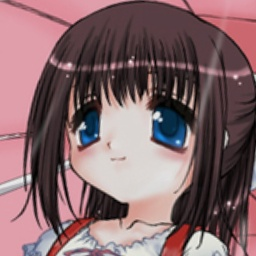

In [8]:
img = utils.load_img(images[0])
img

In [9]:
all_images = []

for i in tqdm(images):
    img = utils.load_img(i)
    img = utils.img_to_array(img)
    img = img/255.0
    all_images.append(img)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 248.71it/s]


In [10]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.1)

In [13]:
Input_img = Input(shape=(256, 256, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)

x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)

x2 = MaxPool2D( (2, 2))(x2)

x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)

x4 = MaxPool2D( (2, 2))(x4)

xNorm = BatchNormalization(center=True, scale=True)(x4)

encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(xNorm)


# decoding architecture

x5 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)

x5 = UpSampling2D((2, 2))(x5)

x6 = Conv2D(32, (3, 3), activation='relu', padding='same')(x5)

x7 = Conv2D(64, (3, 3), activation='relu', padding='same')(x6)
x7 = UpSampling2D((2, 2))(x7)

x8 = Conv2D(128, (3, 3), activation='relu', padding='same')(x7)

x9 = Conv2D(256, (3, 3), activation='relu', padding='same')(x8)

decoded = Conv2D(3, (3, 3), padding='same')(x9)



autoencoder = Model(Input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 256)     7168      
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 128)     295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      73792     
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      18464     
                                                           

In [15]:
a_e = autoencoder.fit(train_x, train_x,
            epochs=10,
            batch_size=5,
            shuffle=True)

Epoch 1/10
18/18 [==============================] - 169s 9s/step - loss: 0.1145
Epoch 2/10
18/18 [==============================] - 164s 9s/step - loss: 0.0453
Epoch 3/10
18/18 [==============================] - 159s 9s/step - loss: 0.0380
Epoch 4/10
18/18 [==============================] - 162s 9s/step - loss: 0.0457
Epoch 5/10
18/18 [==============================] - 155s 9s/step - loss: 0.0296
Epoch 6/10
18/18 [==============================] - 152s 8s/step - loss: 0.0217
Epoch 7/10
18/18 [==============================] - 152s 8s/step - loss: 0.0192
Epoch 8/10
18/18 [==============================] - 151s 8s/step - loss: 0.0237
Epoch 9/10
18/18 [==============================] - 151s 8s/step - loss: 0.0227
Epoch 10/10
18/18 [==============================] - 152s 8s/step - loss: 0.0185


In [34]:
# print(xNorm.gamma)
print(autoencoder.layers[7].beta)
(autoencoder.layers[7].gamma)

<tf.Variable 'batch_normalization_1/beta:0' shape=(32,) dtype=float32, numpy=
array([-0.01562605,  0.00687885,  0.00257271,  0.0022303 , -0.01504694,
        0.01359212,  0.00089391,  0.0170839 ,  0.0047876 ,  0.01180374,
       -0.00727345,  0.01434839, -0.0029447 ,  0.01379738,  0.01088593,
        0.01075754,  0.01485941,  0.01515927,  0.00349937, -0.01668198,
       -0.01063913, -0.00831788, -0.00891261,  0.01666231,  0.01420002,
        0.01756925,  0.00189999, -0.0159473 ,  0.01086108,  0.0114606 ,
        0.0163269 , -0.0130982 ], dtype=float32)>


<tf.Variable 'batch_normalization_1/gamma:0' shape=(32,) dtype=float32, numpy=
array([0.9906162 , 0.99643475, 1.0067977 , 0.99197406, 0.9931828 ,
       0.99859655, 0.9943525 , 0.9849993 , 1.0057813 , 0.994008  ,
       0.99313504, 0.98572683, 0.99342376, 0.9971458 , 0.9956006 ,
       0.9956528 , 0.97521836, 0.9985207 , 0.996472  , 0.99252504,
       0.9970057 , 1.0006577 , 0.9877702 , 0.99273604, 0.993026  ,
       0.9974209 , 0.99750745, 0.9897592 , 0.9954698 , 0.98987824,
       0.9973323 , 0.9970914 ], dtype=float32)>

In [17]:
predictions = autoencoder.predict(test_x)

1/1 [==============================] - 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


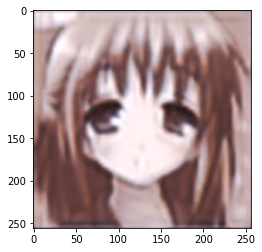

In [18]:
plt.imshow(predictions[3])

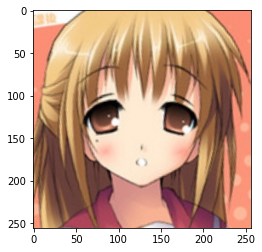

In [20]:
plt.imshow(test_x[3])